In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### Get and use MNIST fashion

https://en.wikipedia.org/wiki/Fashion_MNIST

In [ ]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data)

60000

In [ ]:
len(test_data)

10000

In [ ]:
image, label = train_data[0]

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### Visualize some of the image data

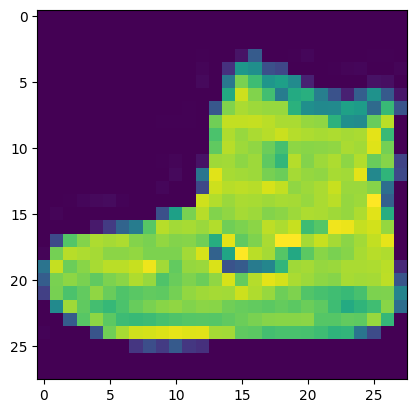

In [ ]:
plt.imshow(image.squeeze()); # squeeze removes the empty dimension

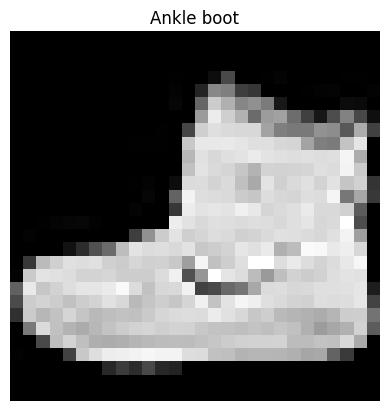

In [ ]:
plt.imshow(image.squeeze(), cmap='gray') # squeeze removes the empty dimension
plt.title(class_names[label])
plt.axis(False);

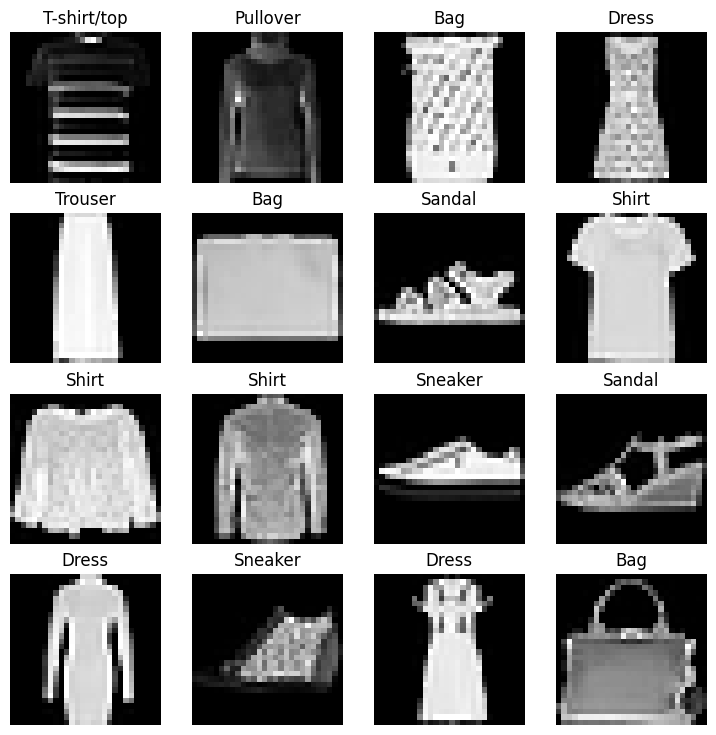

In [ ]:
torch.manual_seed(17)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)


### Create a DataLoader (turns dataset into Python iterable)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train DataLoader: {len(train_dataloader)} batches {BATCH_SIZE}")
print(f"Length of test DataLoader: {len(test_dataloader)} batches {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f618e0bb580>, <torch.utils.data.dataloader.DataLoader object at 0x7f618dd012a0>)
Length of train DataLoader: 1875 batches 32
Length of test DataLoader: 313 batches 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


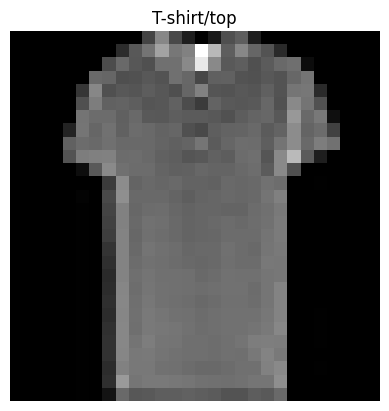

In [ ]:
# show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Build a baseline model (one flatten layer)



In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
# print(x)
# print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features = hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# set up model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

## Setup loss function, optimizer, and evaluation metrics


1.   Loss function - multiclass classification problem -> `nn.CrossEntropyLoss()`
2.   Optimizer - `torch.optim.SGD()` (stochastic gradient descent
3.   Evaluation metrics - Accuracy is fine



In [ ]:
import requests
from pathlib import Path

# download helper functions for this course w/ custom accuracy function
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists here, skipping download....')
else:
  print('Downloading helper_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists here, skipping download....


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

from helper_functions import accuracy_fn

### create a function to time our experiments


In [ ]:
from timeit import default_timer as timer
from time import sleep

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  """Prints the difference between start and end time"""
  total_time = end-start
  print(f"\nTrain time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()
sleep(1)
end_time = timer()
print_train_time(start_time, end_time, "cpu")


Train time on cpu: 1.001 seconds


1.001014251000015

### Create a training loop, train on batches of data


1.   Loop through epochs
2.   Loop through the training batches, perform training steps, calculate train loss _per batch_.
3.   Loop through the testing batches, perform testing evaluations, calculate test loss _per batch_.
4.   Print out results and time elapsed



In [ ]:
from tqdm.auto import tqdm # auto detects your environment!

torch.manual_seed(42)
train_time_start_on_cpu = timer()

EPOCHS = 3

for e in tqdm(range(EPOCHS)):
  print(f"Epoch: {e}\n-------")
  train_loss = 0

  #### training batch loop
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X)

    # 2. calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. optimizer -> zero grad
    optimizer.zero_grad()

    # 4. backpropagate
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

  train_loss /= len(train_dataloader)

  #### testing loop
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%


Train time on cpu: 34.904 seconds


### Make predictions and get results

In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device='cpu')

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Setup device-agnostic code



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Set up better model with nonlinear layers

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                   out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

## Functionize the training / evaluation loop

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a single training step with model trying to learn on dataloader"""
  train_loss, train_acc = 0, 0

  model.train()
  # training batch loop
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. optimizer -> zero grad
    optimizer.zero_grad()

    # 4. backpropagate
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step over data in data_loader"""
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}%\n")

## Train model using our functionalized train/test

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# measure training time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

EPOCHS = 3

for e in tqdm(range(EPOCHS)):
  print(f"Epoch: {e}\n======")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_1.parameters()).device))
print(total_train_time_model_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.0920 | Train acc: 61.3433
Test loss: 0.9564 | Test acc: 64.9960%

Epoch: 1
Train loss: 0.7810 | Train acc: 71.9283
Test loss: 0.7223 | Test acc: 73.9117%

Epoch: 2
Train loss: 0.6703 | Train acc: 75.9367
Test loss: 0.6850 | Test acc: 75.0200%


Train time on cuda:0: 47.447 seconds
47.44689500200002


In [ ]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Convolutional Neural Network

fun example demo here:
https://poloclub.github.io/cnn-explainer/

In [ ]:
class FashionMNISTModelV2(nn.Module):
  """
  Replica of TinyVGG CNN
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier_layer(x)
    # print(f"Output shape of classifier_layer: {x.shape}")
    return x

In [ ]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
# can our image go through the model?
rand_image_tensor = torch.randn(size=[1, 28, 28]).unsqueeze(0).to(device)

In [ ]:
model_2(rand_image_tensor)

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Train this CNN

1.   loss function
2.   optimizer
3.   evaluation metrics



In [ ]:
from helper_functions import accuracy_fn, print_train_time
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
model_2_train_start = timer()

# train and test model
EPOCHS = 3

for e in tqdm(range(EPOCHS)):
  print(f"Epoch: {e+1}\n ========")

  train_step(model_2,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)

  test_step(model_2,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)

model_2_train_stop = timer()

total_train_time_model_2 = print_train_time(start=model_2_train_start,
                                           end=model_2_train_stop,
                                           device=str(next(model_2.parameters()).device))
print(total_train_time_model_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.5931 | Train acc: 78.3733
Test loss: 0.3854 | Test acc: 86.3918%

Epoch: 2
Train loss: 0.3580 | Train acc: 87.0883
Test loss: 0.3520 | Test acc: 87.3602%

Epoch: 3
Train loss: 0.3221 | Train acc: 88.4083
Test loss: 0.3388 | Test acc: 87.7496%


Train time on cuda:0: 49.875 seconds
49.87528079200001


In [ ]:
model_2_results = eval_model(
    model_2, test_dataloader, loss_fn, accuracy_fn, device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3387972116470337,
 'model_acc': 87.74960063897764}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## Comparing results across experiments

In [ ]:
import pandas as pd

model_df = pd.DataFrame([model_0_results, model_1_results, model_2_results])
model_df['training_times'] = [total_train_time_model_0,
                              total_train_time_model_1,
                              total_train_time_model_2]

model_df

,model_name,model_loss,model_acc,training_times
0,FashionMNISTModelV0,0.476639,83.426518,34.903619
1,FashionMNISTModelV1,0.685001,75.019968,47.446895
2,FashionMNISTModelV2,0.338797,87.749601,49.875281


Text(0, 0.5, 'model')

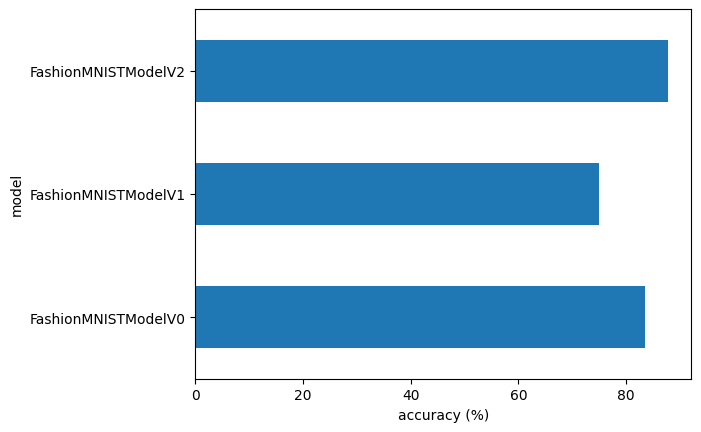

In [ ]:
model_df.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)


In [ ]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape


torch.Size([1, 28, 28])

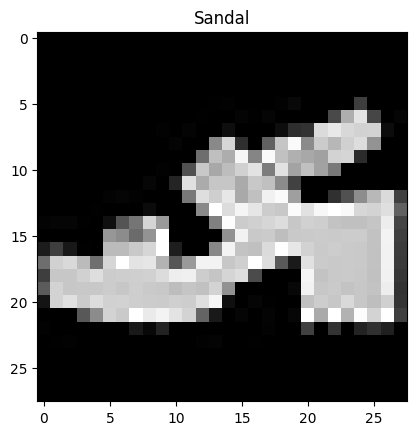

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]);

In [ ]:
pred_probs = make_predictions(model_2, test_samples)

pred_probs[:2]

tensor([[6.6796e-08, 3.2918e-08, 1.1562e-08, 1.1457e-08, 3.0812e-09, 9.9997e-01,
         9.4211e-09, 1.9218e-07, 2.9248e-06, 2.6919e-05],
        [2.3874e-03, 9.8025e-01, 1.3209e-04, 1.5637e-02, 5.0013e-04, 6.2004e-05,
         1.0190e-03, 5.8935e-06, 6.7380e-06, 4.3179e-06]])

In [ ]:
# convert to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

## Plot some predictions

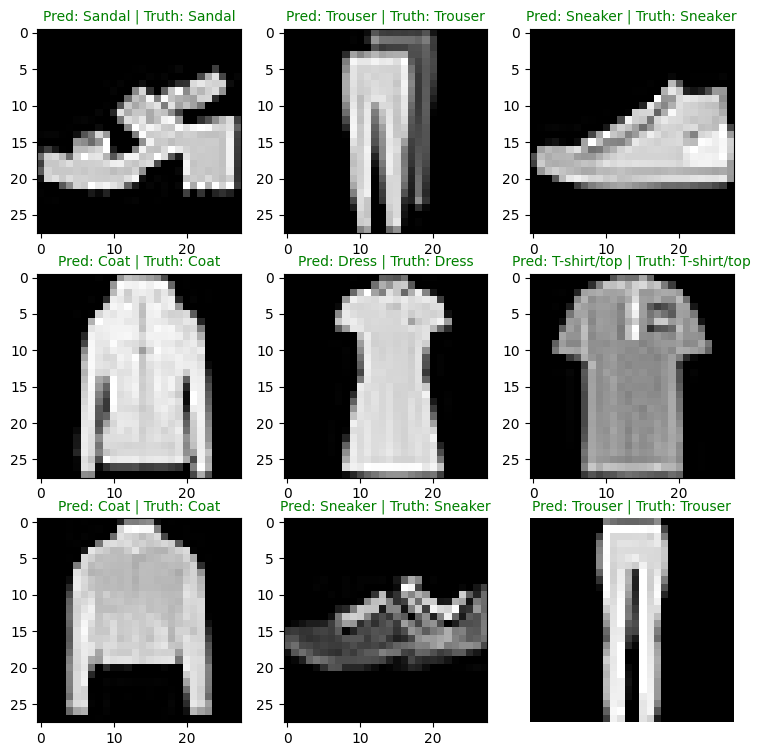

In [ ]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

plt.axis(False);

### Confusion matrix for evaluating model

In [ ]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_preds_tensor = torch.cat(y_preds)
print(y_preds_tensor[:5])


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6])


In [ ]:
# some fun metrics libraries

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19), "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0
mlxtend version: 0.22.0


In [ ]:
mlxtend.__version__

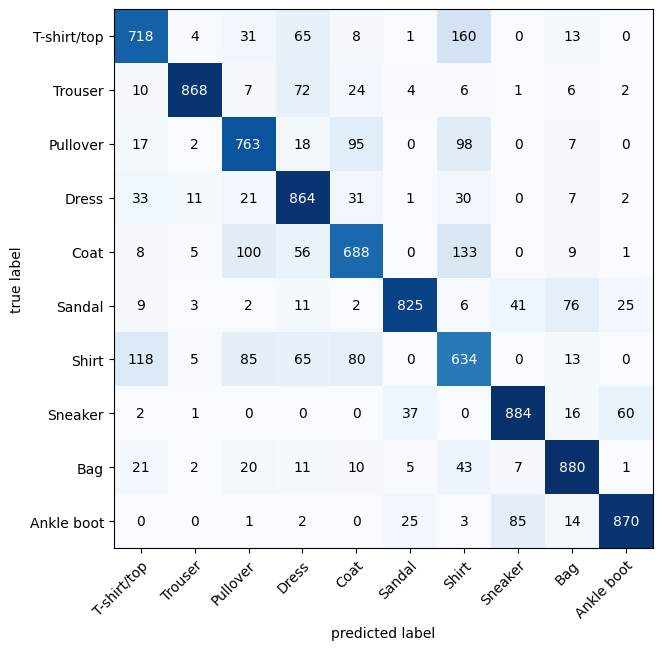

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

## Saving and loading our best model

In [ ]:
from pathlib import Path

# saving
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
# loading
torch.manual_seed(42)
loaded_model_v2 = FashionMNISTModelV2(input_shape=1,
                                      hidden_units=10,
                                      output_shape=len(class_names))


loaded_model_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_v2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# evaluate loaded model
model_2_results # previous model

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3387972116470337,
 'model_acc': 87.74960063897764}

In [ ]:
torch.manual_seed(42)
loaded_model_2_results = eval_model(loaded_model_v2,
                                    test_dataloader,
                                    loss_fn,
                                    accuracy_fn,
                                    device)

loaded_model_2_results # loaded model

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3387972116470337,
 'model_acc': 87.74960063897764}

In [ ]:
# torch has a method for this!

torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']),
              atol=1e-8)

tensor(True)

In [ ]:
# could access and compare the w and b with some finagling

state_dict_compare = torch.isclose(model_2.state_dict()['conv_block_2.2.weight'],
                                   loaded_model_v2.state_dict()['conv_block_2.2.weight'],
                                   atol=1e-8)

sum(state_dict_compare.flatten()) / len(state_dict_compare.flatten())

tensor(1., device='cuda:0')